In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from stable_baselines import DQN
from stable_baselines.common.vec_env import DummyVecEnv

from dmarket.environments import SingleAgentTrainingEnv
from dmarket.agents import UniformRandomAgent, GymRLAgent, TimeLinearAgent, TimeDependentAgent
from dmarket.info_settings import OfferInformationSetting, TimeInformationWrapper

Consider a simple memory-based seller. The seller offers in the interval ``[50, 100]`` and has the following strategy. If he sees that someone is bidding above 90, he will increase ``count`` by one in his internal memory. He will then offer ``100 - count``. If, however, during some round ``count >= 3``, then he will throw a large discount and offer to sell at 50.

In [2]:
class TrickySeller(TimeDependentAgent):
    def compute_offer(self, obs, time):
        if time == 0:
            self.count = 0
            
        if self.count >= 3:
            # DISCOUNT TIME!!!
            return 50
        else:
            best_bid = obs[0][0]
            if best_bid >= 90:
                self.count += 1
            return 100 - self.count

Set up environment for baselines training!

In [3]:
rl_agent = GymRLAgent('buyer', 100, 'B1', max_factor=0.5, discretization=10)

fixed_agents = [
    TrickySeller('seller', 50,  'TS')
]

setting = TimeInformationWrapper(OfferInformationSetting(1))

def get_env(rl_agent, fixed_agents, setting):
    return SingleAgentTrainingEnv(rl_agent, fixed_agents, setting)

env = DummyVecEnv([lambda: get_env(rl_agent, fixed_agents, setting)]) # wrap it for baselines

Since the RL-agent has a discrete action space (integers from 0 to 9 inclusive), let's see what prices RL agent can offer:

In [4]:
[(action, rl_agent.action_to_price(action)) for action in range(rl_agent.discretization)]

[(0, 100.0),
 (1, 95.0),
 (2, 90.0),
 (3, 85.0),
 (4, 80.0),
 (5, 75.0),
 (6, 70.0),
 (7, 65.0),
 (8, 60.0),
 (9, 55.0)]

Hence, the maximal reward the agent can get is 47.5. To do this, he needs to follow the following sequence: offer 3 times 95 to trigger the seller and then offer 55. At the last step, the seller will offer 50, so the midprice would be 52.5.

Let's see if the DQN algorithm can learn this simple policy. **Note: the RL agent will not be able to access the time information, only the last best offers**. The seller will signal how long until it will drop the price by 50.

We will set the algorithm to do a lot of exploration: anywhere between 30% to 50% of the time it will do something random. The discount rate is set to 90%, so that the agent is pushed to quickly trigger the correct sequence to obtain the reward.

In [5]:
model = DQN("LnMlpPolicy", env, verbose=1, 
            gamma=0.90, exploration_fraction=0.5,
            exploration_final_eps=0.3,
            prioritized_replay=True)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Learn for 10000 steps, which should take about a minute, and we keep track of the episodes and rewards.

In [6]:
episodes = []
rewards = []
def log_rewards(lvar, gvar):
    try:
        ep = lvar['num_episodes']
        if ep >= 10000: return False
        if ep % 100 == 0:
            rewards.append(lvar['mean_100ep_reward'])
            episodes.append(lvar['num_episodes'])
    except KeyError:
        return True
    return True

In [7]:
%%time
model.learn(total_timesteps=10000, callback=log_rewards)

--------------------------------------
| % time spent exploring  | 90       |
| episodes                | 100      |
| mean 100 episode reward | 9.4      |
| steps                   | 664      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 82       |
| episodes                | 200      |
| mean 100 episode reward | 6.4      |
| steps                   | 1270     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 76       |
| episodes                | 300      |
| mean 100 episode reward | 3.7      |
| steps                   | 1714     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 68       |
| episodes                | 400      |
| mean 100 episode reward | 10.3     |
| steps                   | 2261     |
--------------------------------------
--------------------------------------
| % time spent exploring 

## Plot training data

In [8]:
df = pd.DataFrame(rewards, index=episodes)
df.index.name = 'Episodes'
df.columns = ['Mean Rewards']

In [9]:
import sys
sys.path.append("..")
from plot_config import *

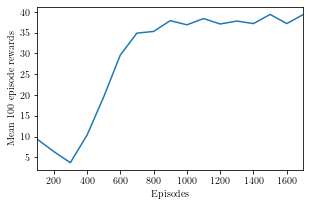

In [15]:
fig, ax = plt.subplots(1)
df.plot(ax=ax, legend=False)
ax.set(ylabel="Mean 100 episode rewards")
fig.set_size_inches(w=4.7747, h=3.)


In [16]:
fig.savefig('single_agent_trickyseller_train.pgf')

In [12]:
def plot_transition(agent, fig, ax):
    data = []
    for price in range(100, 50, -1):
        data.append(agent.model.action_probability(
            rl_agent.normalize(np.array([
                [0],
                [price],
            ])
        )))
    prices = list(range(100, 50, -1))
    df = pd.DataFrame(data, index=prices)
    min_offer = agent._a
    max_offer = agent._b
    im = ax.imshow(np.array(data), extent=[max_offer, min_offer, min_offer, max_offer])
    ax.set(xlabel='Next offer probability')
    ax.set(ylabel='Best last ask')
    fig.colorbar(im)
    fig.set_size_inches(w=4.7747, h=3.)

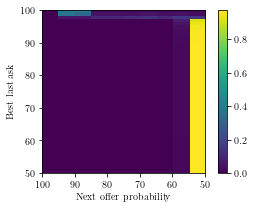

In [13]:
rl_agent.model = model
fig, ax = plt.subplots(1)
#df.plot(ax=ax, legend=False)
plot_transition(rl_agent, fig, ax)
plt.savefig('single_agent_trickyseller_qtable.pgf')